In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.0
Torchvision version: 0.19.0
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-k_uhx8_q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-k_uhx8_q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-10-04 17:56:21--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: 'images/dog.jpg'

dog.jpg             100%[===================>]  97.51K  --.-KB/s    in

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
image = cv2.imread('/kaggle/input/vishal-avataar-examples/lamp.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

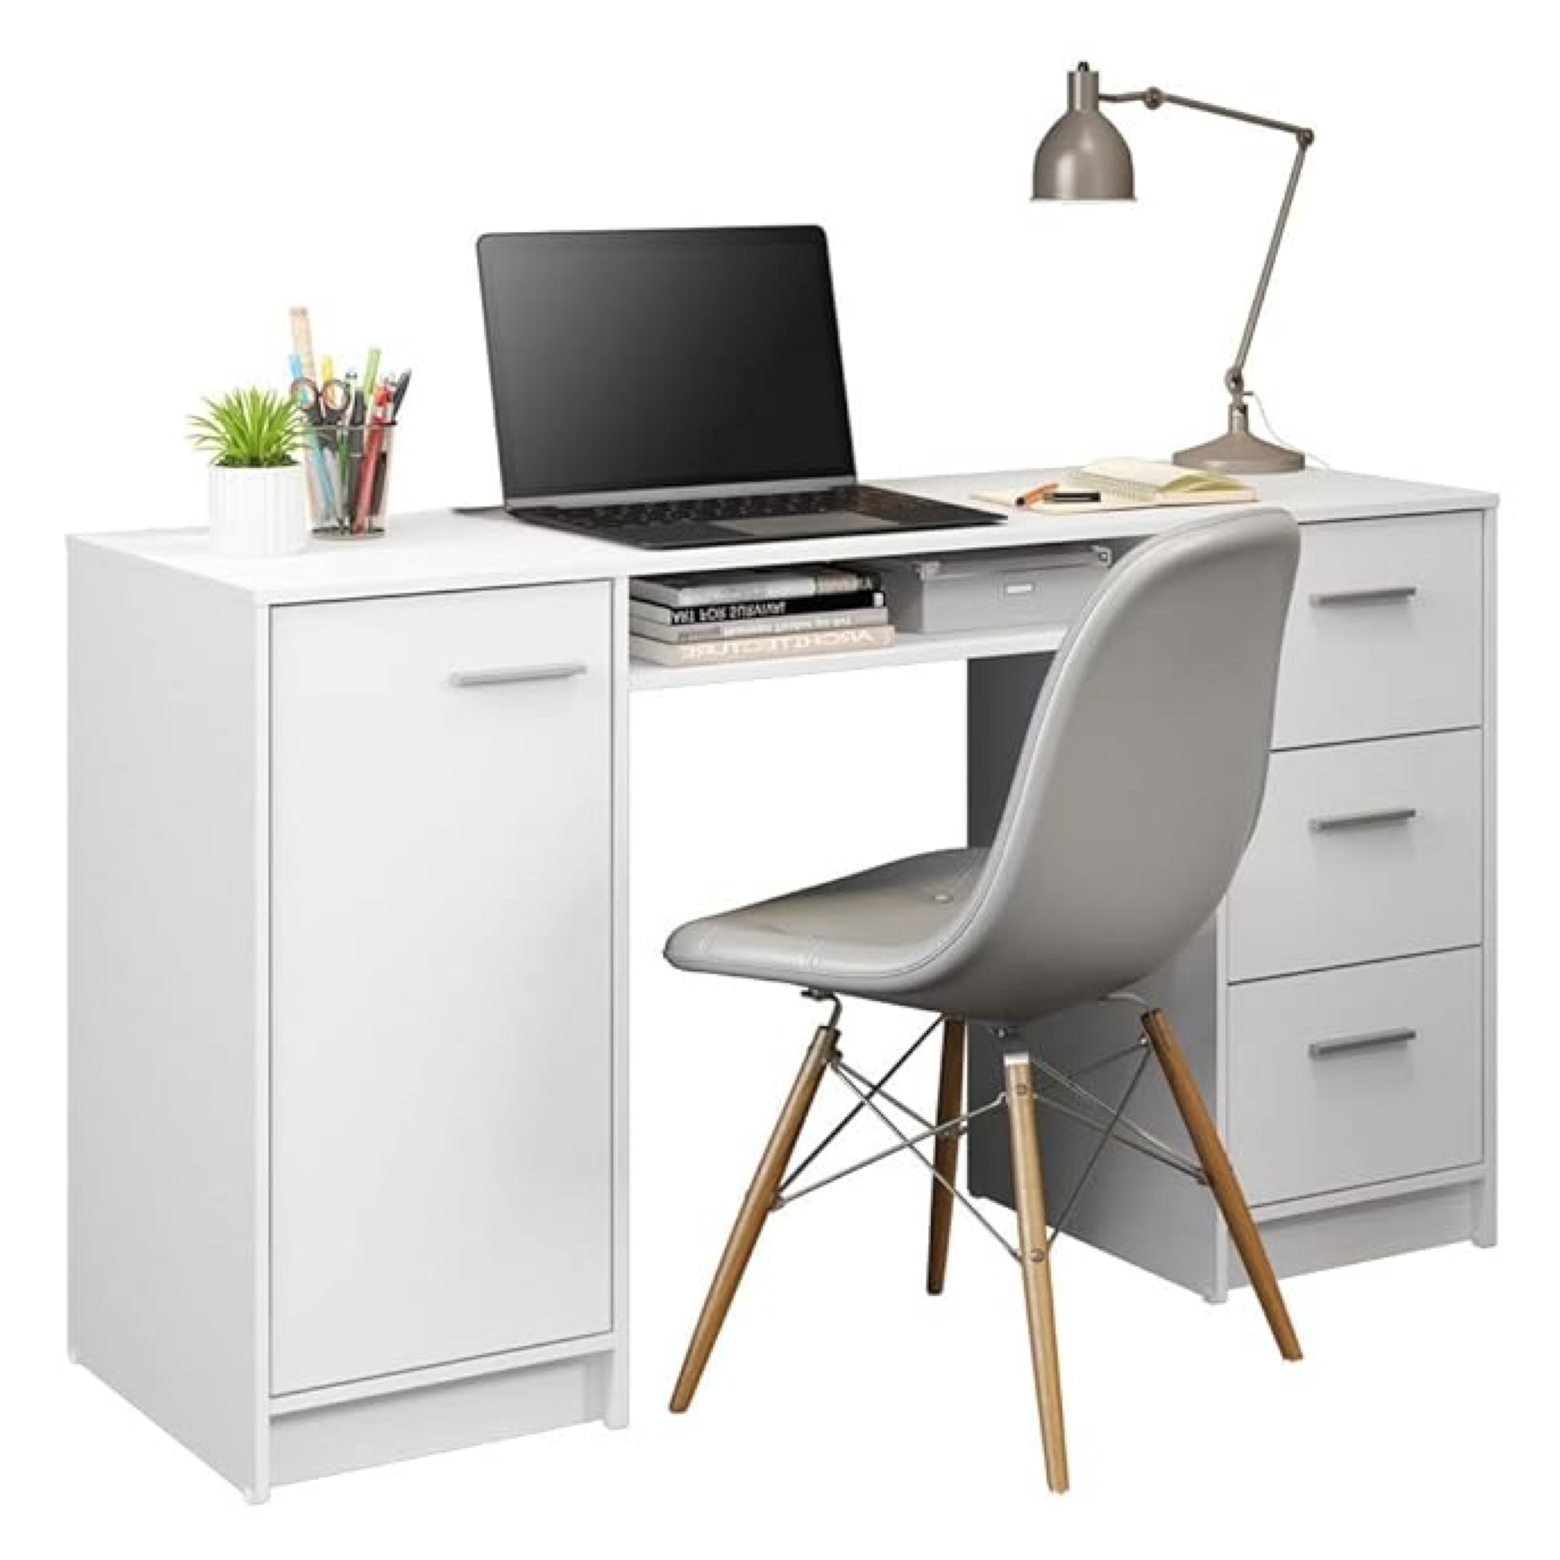

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [7]:
masks = mask_generator.generate(image)

In [8]:
print(len(masks))
print(masks[0].keys())

53
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


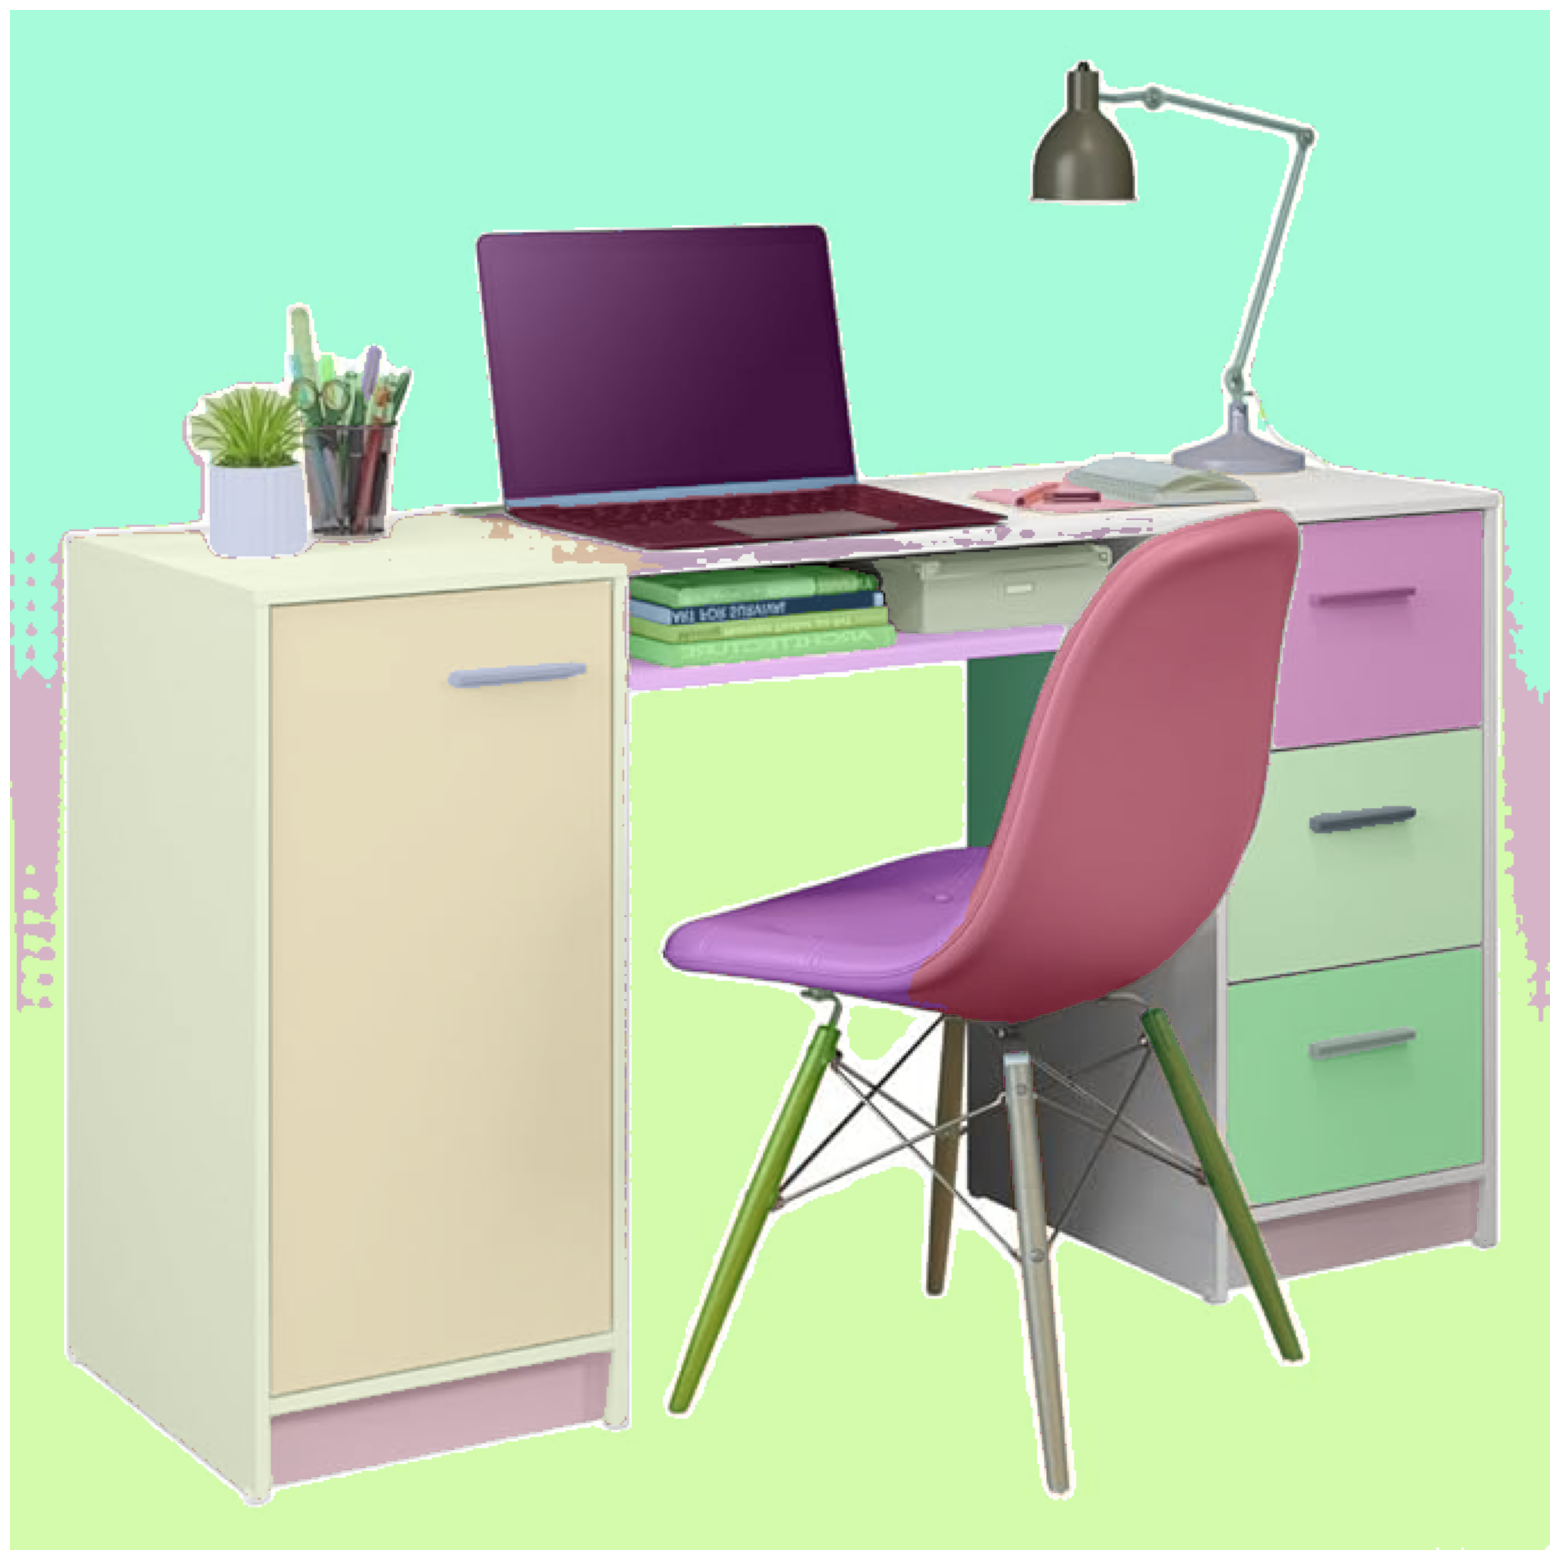

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [20]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.86,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
masks2 = mask_generator_2.generate(image)

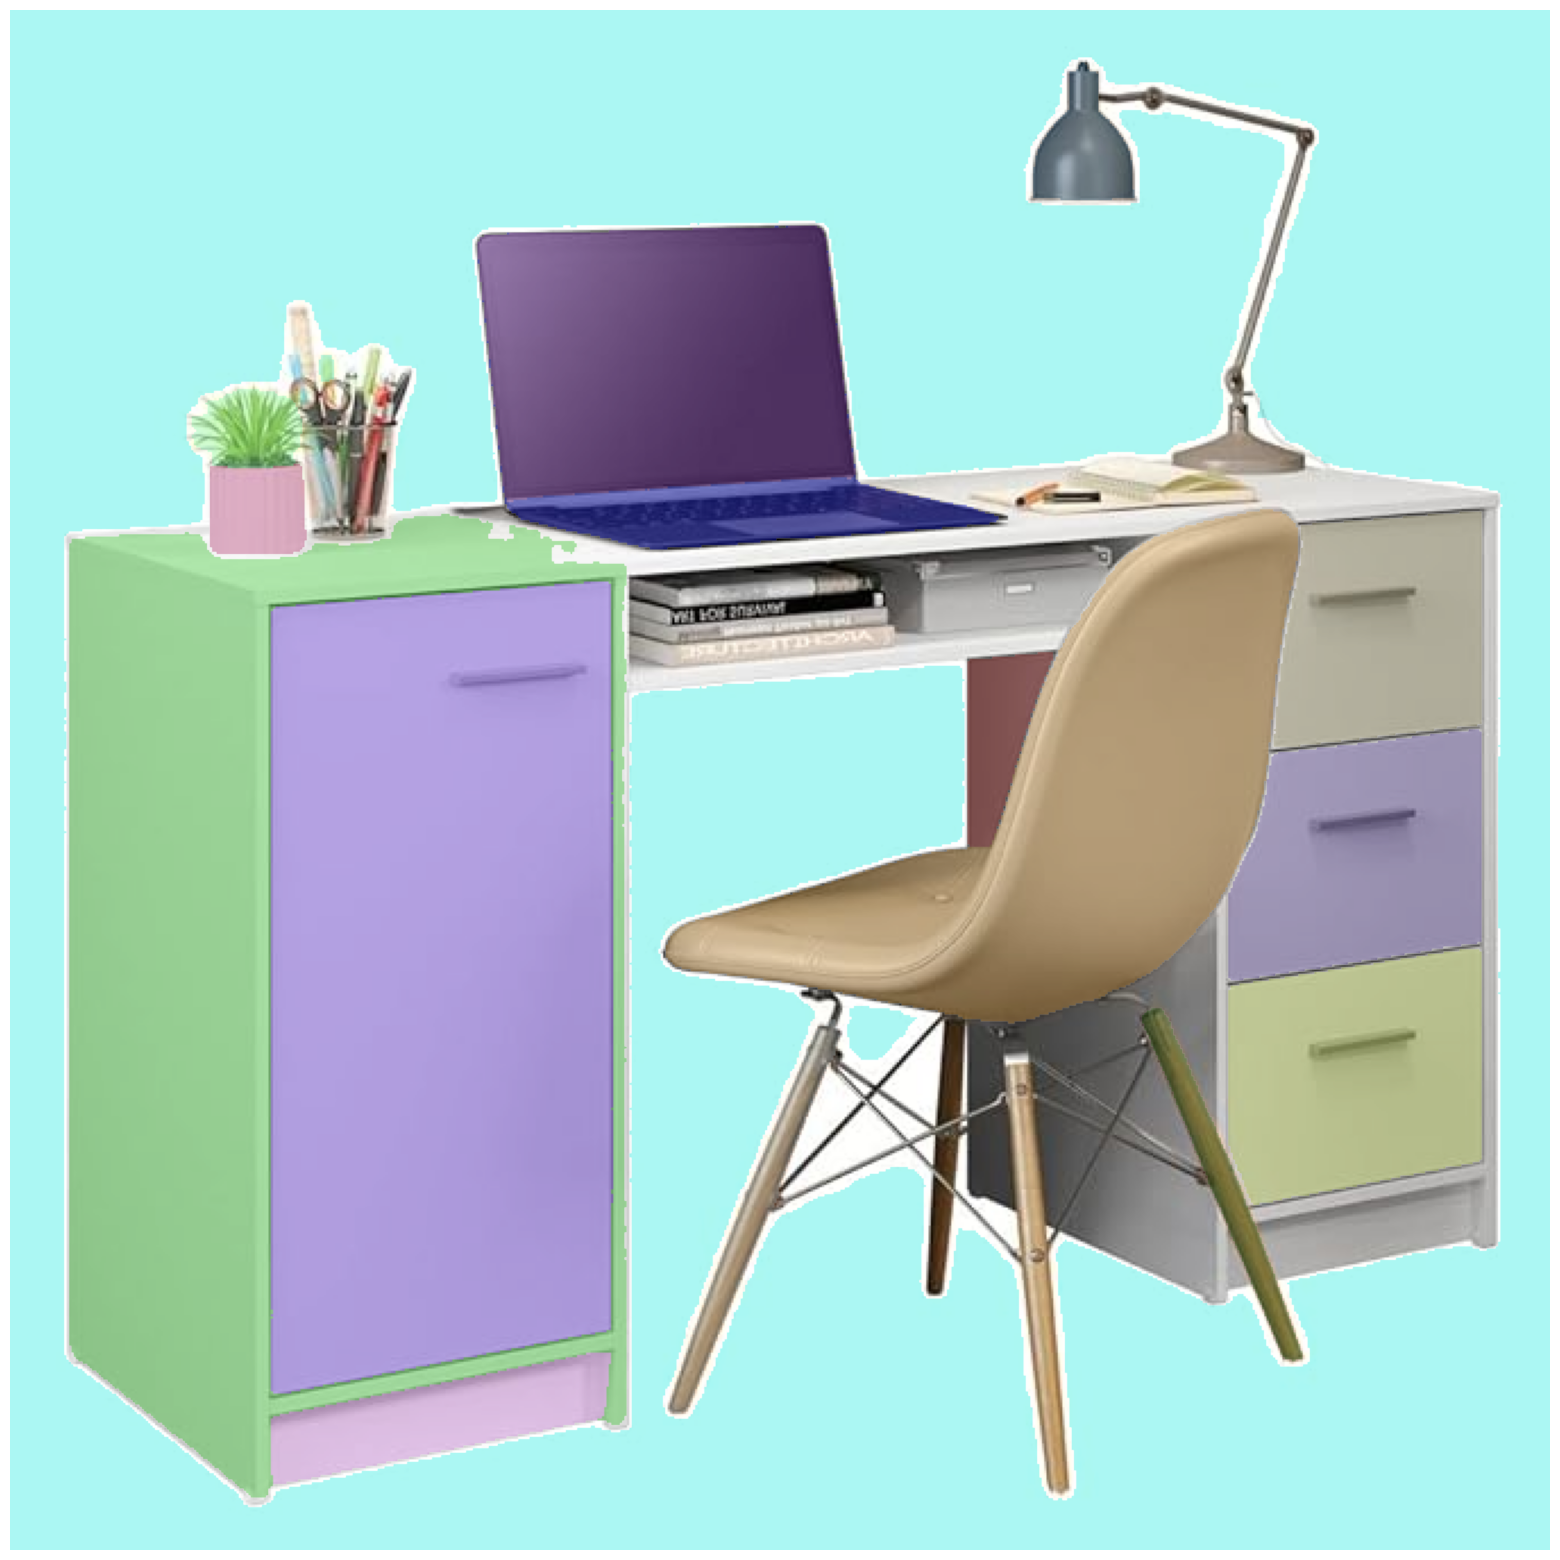

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

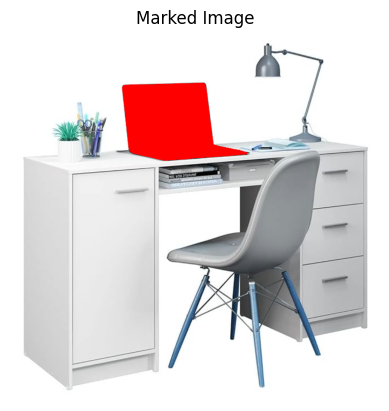

In [22]:

def mark_object(image, prompt, masks_f):
    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Check if the masks array is empty
    if len(masks_f) == 0:
        raise ValueError("No masks found in the segmentation output.")

    # Select the appropriate mask based on the prompt
    if prompt.lower() == 'table':
        selected_mask = masks_f[0]['segmentation']  # Adjust according to the structure of masks
    else:
        raise ValueError(f"No mask available for prompt: {prompt}")

    # Ensure selected_mask is a boolean array
    if isinstance(selected_mask, np.ndarray) and selected_mask.ndim == 2:
        combined_mask[selected_mask] = 255  # Set selected mask pixels to 255
    else:
        raise ValueError("The selected mask must be a 2D boolean array.")

    output_image = image.copy()
    output_image[combined_mask > 0] = [0, 0, 255]  # Mark the object red

    return output_image

# Example usage
prompt = 'table'  # Your prompt
output_image = mark_object(image, prompt, masks)

# Save the output image
cv2.imwrite('marked_image.jpg', output_image)

# Display the output image using Matplotlib
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.title('Marked Image')
plt.show()

In [23]:
pip install diffusers transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
